<a href="https://colab.research.google.com/github/Ailton3112/glp/blob/main/RevGas_V01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Consumption Forecast GLP

In this notebook, I will use the Produtos_Clientes.csv to build an unsupervised machine learning model which allows one to estimate if a given customer will buy something again from the online shop in the next quarter. 

<a id="problem-statements"></a>
## Problem Statements 

As part of the main problem that will be tackled in this notebook, I will discuss in section named 

1. How many online customers are there in the dataset and what is their city/state of origin?

2. What are the cities/state that are most represented in the dataset?

3. Calculate the revenue that was made in each month and what is the percentage revenue based on the various cities/state?

<a id="toc"></a>
## Table of Contents

* [ ] [<font color=blue>Importing Relevant Python Packages</font>](#importing-relevant-python-packages)
[comment]: <> (Something)
* [ ] [<font color=blue>Importing Relevant Data</font>](#importing-relevant-data)
[comment]: <> (Something)
* [ ] [<font color=blue>Data Engineering</font>](#data-engineering)
    * [<font color=blue>Exploration Question 1</font>](#exp-qxn-1)
    * [<font color=blue>Exploration Question 2</font>](#exp-qxn-2)
    * [<font color=blue>Exploration Question 3</font>](#exp-qxn-3)
    * [<font color=blue>Predicting Customer Purchase</font>](#predicting-customer-purchase)
[comment]: <> (Something) 
* [ ] [<font color=blue>Building Machine Learning Models</font>](#building-machine-learning-models)
[comment]: <> (Something)
* [ ] [<font color=blue>Conclusion</font>](#conclusion)

<a id="importing-relevant-python-packages"></a>
## Importing Relevant Python Packages

In [ ]:
# importing necessary Python libraries

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
#import plotly.offline as pyoff
import plotly.graph_objs as go 
#import plotly.figure_factory as ff

# avoid displaying warnings
import warnings
warnings.filterwarnings("ignore")

#import machine learning related libraries
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate
from multiscorer import MultiScorer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.cluster import KMeans
import xgboost as xgb
import time
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, train_test_split
from scipy import interp
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix

In [ ]:
# def enable_plotly_in_cell():
#   import IPython
#   from plotly.offline import init_notebook_mode
#   display(IPython.core.display.HTML('''<script src="/static/components/requirejs/require.js"></script>'''))
#   init_notebook_mode(connected=False)

<a id='connect-gdrive'></a>
## Connect GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<a id='importing-relevant-data'></a>
## Importing Relevant Data

In [ ]:
# Loading the data

df_data_origem = pd.read_csv('/content/drive/MyDrive/REVGAS/dados/produtos_clientes.csv',delimiter = ',',low_memory=False)

df_data= df_data_origem.query("(state=='Piauí') & (quantity_product<='2') & (product=='GLP 13KG')").reset_index(drop=True)
df_data.head()


,client_id,quantity_product,product,value_product,payments,payments_values,total,date,city,state
0,29293,1,GLP 13KG,45.00,Dinheiro,45.00,45.0,2013-04-09 22:17:37,Teresina,Piauí
1,29293,1,GLP 13KG,40.00,Dinheiro,40.00,40.0,2013-05-18 23:12:27,Teresina,Piauí
2,29293,1,GLP 13KG,45.00,Dinheiro,45.00,45.0,2013-06-25 22:21:47,Teresina,Piauí
3,29293,1,GLP 13KG,45.00,Dinheiro,45.00,45.0,2013-08-11 21:51:12,Teresina,Piauí
4,29293,1,GLP 13KG,45.00,Dinheiro,45.00,45.0,2013-10-17 22:57:38,Teresina,Piauí


<a id='data-engineering'></a>
## Data Engineering

In this section, we will explore the given dataset to answer some general questions about the dataset. This will lead to cause us to introduce other features into the dataset which will help us to build a machine learning model that will help us to answer our main question.

Let's update the pandas dataframe `df` by renaming some of its columns.

We can check information about the dataframe with the `info` method. 

In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 620912 entries, 0 to 620911
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         620912 non-null  int64  
 1   quantity_product  620912 non-null  object 
 2   product           620912 non-null  object 
 3   value_product     620912 non-null  object 
 4   payments          620912 non-null  object 
 5   payments_values   620912 non-null  object 
 6   total             620912 non-null  float64
 7   date              620912 non-null  object 
 8   city              620912 non-null  object 
 9   state             620912 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 47.4+ MB


In [ ]:
df_data.isnull().sum()

client_id           0
quantity_product    0
product             0
value_product       0
payments            0
payments_values     0
total               0
date                0
city                0
state               0
dtype: int64

Next, we update the dataframe `df_data` by converting the date field, __date__ to _datetime_ object. One can use the `to_datetime` method to achieve this.

In [ ]:
df_data.date = pd.to_datetime(df_data.date)
df_data.head()

,client_id,quantity_product,product,value_product,payments,payments_values,total,date,city,state
0,29293,1,GLP 13KG,45.00,Dinheiro,45.00,45.0,2013-04-09 22:17:37,Teresina,Piauí
1,29293,1,GLP 13KG,40.00,Dinheiro,40.00,40.0,2013-05-18 23:12:27,Teresina,Piauí
2,29293,1,GLP 13KG,45.00,Dinheiro,45.00,45.0,2013-06-25 22:21:47,Teresina,Piauí
3,29293,1,GLP 13KG,45.00,Dinheiro,45.00,45.0,2013-08-11 21:51:12,Teresina,Piauí
4,29293,1,GLP 13KG,45.00,Dinheiro,45.00,45.0,2013-10-17 22:57:38,Teresina,Piauí


In [ ]:
pd.DataFrame(df_data.date.describe())

,date
count,620912
unique,591496
top,2014-03-03 20:00:00
freq,65
first,2013-01-24 21:50:36
last,2022-01-17 21:32:46


From the above, we see that the online purchases made by customers was from 2013-01-24  to 2022-01-17.

In the subsequent cells, we will answer some questions we would like to know from the given dataset.

<a id='exp-qxn-1'></a>
### Exploration Question 1
> How many online customers are there in the dataset and what is their cities/states of origin?

In [ ]:
print('From the dataset, the online retail shop has {} customers \
from {} different cities.'.format(len(df_data.client_id.unique()), len(df_data.city.unique())))

From the dataset, the online retail shop has 74542 customers from 77 different cities.


<a id='exp-qxn-2'></a>
### Exploration Question 2
> What are the cities/states that are most represented in the dataset?

In [ ]:
ctm_cntry_df = df_data.groupby(['client_id', 'city']).count().reset_index()

ctm_cntry_df = ctm_cntry_df.groupby('city')['client_id'].count().reset_index().sort_values(
    by=['client_id'], ascending=False)

# Create a new column, Percentage to calculate the customer representation in percentage
ctm_cntry_df['Percentage']= np.round(ctm_cntry_df.client_id / ctm_cntry_df.client_id.sum() * 100, 2)

ctm_cntry_df.head(10)

,city,client_id,Percentage
71,Teresina,39792,53.38
15,Campo Maior,6906,9.26
53,Piripiri,6087,8.17
4,Amarante,3882,5.21
3,Altos,2557,3.43
72,Valença do Piauí,2205,2.96
5,Angical do Piauí,2060,2.76
62,São Gonçalo do Piauí,1923,2.58
54,Regeneração,1365,1.83
48,Parnaíba,1034,1.39


The output above, shows the top $10$ cities of that purchase from the online retail shop with the Teresina being the city with the highest customers. They represent about $53.38\%$ of the entire online customers. 

In the two next cells, we group cities with customer percentage value less 
than or equal to $0.25$ together and then plot a pie chart. 

In [ ]:
percent_margin = 0.25

# Create a new column, CountryCategory and set values to the corresponding values of the Country column
ctm_cntry_df['CityCategory'] = ctm_cntry_df.city

# Set Countries with Percentage less than or equal to percent_margin to 'Other Countries'

ctm_cntry_df.loc[ctm_cntry_df.Percentage <= percent_margin, 'CityCategory'] = 'Other Cities'

ctm_cntry_df.head()

,city,client_id,Percentage,CityCategory
71,Teresina,39792,53.38,Teresina
15,Campo Maior,6906,9.26,Campo Maior
53,Piripiri,6087,8.17,Piripiri
4,Amarante,3882,5.21,Amarante
3,Altos,2557,3.43,Altos


In [ ]:
import plotly.io as pio
pio.renderers.default='colab'


In [ ]:
# plot pie chart

pie_fig = px.pie(ctm_cntry_df, 
                 names="CityCategory", 
                 values="Percentage", 
                 title="Customer City Count in Percentage", 
                 template= "plotly_dark"
                )

pie_fig.update_layout(title_x=0, 
                      legend_title="Cities Represented", 
                      legend=dict(orientation="h")
                     )

pie_fig.show()

<a id='exp-qxn-3'></a>
### Exploration Question 3
> Calculate the revenue that was made in each month and what is the percentage revenue based on cities/states?

In [ ]:
df_data['InvoiceYearMonth'] = df_data['date'].map(lambda date: 100*date.year + date.month)
df_data['Month'] = df_data['date'].map(lambda date: date.month)
df_data.set_index('Month')
df_data.head()

,client_id,quantity_product,product,value_product,payments,payments_values,total,date,city,state,InvoiceYearMonth,Month
0,29293,1,GLP 13KG,45.00,Dinheiro,45.00,45.0,2013-04-09 22:17:37,Teresina,Piauí,201304,4
1,29293,1,GLP 13KG,40.00,Dinheiro,40.00,40.0,2013-05-18 23:12:27,Teresina,Piauí,201305,5
2,29293,1,GLP 13KG,45.00,Dinheiro,45.00,45.0,2013-06-25 22:21:47,Teresina,Piauí,201306,6
3,29293,1,GLP 13KG,45.00,Dinheiro,45.00,45.0,2013-08-11 21:51:12,Teresina,Piauí,201308,8
4,29293,1,GLP 13KG,45.00,Dinheiro,45.00,45.0,2013-10-17 22:57:38,Teresina,Piauí,201310,10


In [ ]:
df_data["value_product"]    = pd.to_numeric(df_data["value_product"], errors='coerce')
df_data["quantity_product"] = pd.to_numeric(df_data["quantity_product"], errors='coerce')


df_data['Revenue'] = df_data.value_product * df_data.quantity_product
df_data.head()

,client_id,quantity_product,product,value_product,payments,payments_values,total,date,city,state,InvoiceYearMonth,Revenue
0,29293,1,GLP 13KG,45.0,Dinheiro,45.00,45.0,2013-04-09 22:17:37,Teresina,Piauí,201304,45.0
1,29293,1,GLP 13KG,40.0,Dinheiro,40.00,40.0,2013-05-18 23:12:27,Teresina,Piauí,201305,40.0
2,29293,1,GLP 13KG,45.0,Dinheiro,45.00,45.0,2013-06-25 22:21:47,Teresina,Piauí,201306,45.0
3,29293,1,GLP 13KG,45.0,Dinheiro,45.00,45.0,2013-08-11 21:51:12,Teresina,Piauí,201308,45.0
4,29293,1,GLP 13KG,45.0,Dinheiro,45.00,45.0,2013-10-17 22:57:38,Teresina,Piauí,201310,45.0


In [ ]:
ctm_revenue = df_data.groupby('InvoiceYearMonth').Revenue.sum().reset_index()
ctm_revenue.head()

,InvoiceYearMonth,Revenue
0,201301,565.0
1,201302,11149.0
2,201303,75485.0
3,201304,77374.0
4,201305,76448.0


In [ ]:
pd.DataFrame(ctm_revenue.Revenue.describe())

,Revenue
count,1.090000e+02
mean,5.786536e+05
std,4.914816e+05
min,5.650000e+02
25%,1.780025e+05
50%,5.423470e+05
75%,7.531265e+05
max,1.903770e+06


In [ ]:
# plot line plot
line_fig = px.line(ctm_revenue, 
                   x = "InvoiceYearMonth", 
                   y = "Revenue", 
                   title = "Montly Revenue from Jan. 2013 to Jan. 2022", 
                   template= "plotly_dark" 
                  )

line_fig.update_layout(title_x=0.5, 
                       showlegend=False, 
                       xaxis={"type": "category"}, 
                       xaxis_title="Invoice Year-Month", 
                       yaxis_title="Monthly Revenue"
                      )

line_fig.show()

From the graph figure above, we observe that the online retail shop made the highest sales in November 2010, followed by November 2011. Also, one can observe that, monthly sales rises after August. 

Next, explore the percentage revenue generated by the retail shop based on the countries their customers reside.

In [ ]:
cntry_revenue_df = df_data.groupby(['city']).Revenue.sum().reset_index().sort_values(by=['Revenue'], 
                                                                                        ascending=False)

cntry_revenue_df['Percentage'] = np.round(cntry_revenue_df.Revenue / cntry_revenue_df.Revenue.sum() * 100, 2)

cntry_revenue_df.head(5)

,city,Revenue,Percentage
71,Teresina,26546639.70,42.09
4,Amarante,5715631.30,9.06
72,Valença do Piauí,5610976.99,8.90
54,Regeneração,3609489.00,5.72
51,Picos,2626315.34,4.16


From the output above, the top $5$ cities with respect to revenue generated are:
 * Teresina
 * Amarante
 * Valença do Piauí
 * Regeneração 
 * Picos

with the _Teresina_ recording the highest in percentage $(42.09\%)$. 

In the next two cells, we update `cntry_revenue_df` with a new 

In the two next cells, we group cities with revenue percentage value less than or equal to $0.25$ together and then plot a pie chart. 

In [ ]:
percent_margin = 0.25

# Create a new column, CountryCategory and set values to the corresponding values of the Country column
cntry_revenue_df['CityCategory'] = cntry_revenue_df.city

# Set Countries with Percentage less than or equal to percent_margin to 'Other Countries'

cntry_revenue_df.loc[cntry_revenue_df.Percentage <= percent_margin, 'CityCategory'] = 'Other Countries'

cntry_revenue_df.head()

,city,Revenue,Percentage,CityCategory
71,Teresina,26546639.70,42.09,Teresina
4,Amarante,5715631.30,9.06,Amarante
72,Valença do Piauí,5610976.99,8.90,Valença do Piauí
54,Regeneração,3609489.00,5.72,Regeneração
51,Picos,2626315.34,4.16,Picos


In [ ]:
# plot pie chart
pie_fig = px.pie(cntry_revenue_df, 
                 names="CityCategory", 
                 values="Percentage", 
                 title="City Revenue in Percentage", 
                 template= "plotly_dark"
                )

pie_fig.update_layout(title_x=0, 
                      legend_title="Cities Represented", 
                      legend=dict(orientation="h")
                     )

#pie_fig.show(config={'displaylogo': False})
pie_fig.show()

<a id='predicting-customer-purchase'></a>
## Predicting Customer Purchase 

The goal of this section is to come up with a make a model using the given dataframe `df_data`, to estimate if a given customer will buy something again from the online shop in the next quarter. 

The dataframe is split into two. 

* The first sub-dataframe assigned to the Python variable `ctm_bhvr_dt` contains purchases made by customers from `24/01/2013` to `30/09/2021`. This dataframe will be used to study the behavioural purchases of the online customers. 

* The second sub-dataframe assigned to the Python variable `ctm_next_quarter` will be used to study the behavioural purchases of the customers in the next quarter. That is, from `01/10/2021` to `17/01/2022`

In [ ]:
df_data.head()

,client_id,quantity_product,product,value_product,payments,payments_values,total,date,city,state,InvoiceYearMonth,Revenue
0,29293,1,GLP 13KG,45.0,Dinheiro,45.00,45.0,2013-04-09 22:17:37,Teresina,Piauí,201304,45.0
1,29293,1,GLP 13KG,40.0,Dinheiro,40.00,40.0,2013-05-18 23:12:27,Teresina,Piauí,201305,40.0
2,29293,1,GLP 13KG,45.0,Dinheiro,45.00,45.0,2013-06-25 22:21:47,Teresina,Piauí,201306,45.0
3,29293,1,GLP 13KG,45.0,Dinheiro,45.00,45.0,2013-08-11 21:51:12,Teresina,Piauí,201308,45.0
4,29293,1,GLP 13KG,45.0,Dinheiro,45.00,45.0,2013-10-17 22:57:38,Teresina,Piauí,201310,45.0


In [ ]:
## 8 anos
#ctm_bhvr_dt = df_data[(df_data.date < pd.Timestamp(2021,12,1)) & 
#      (df_data.date >= pd.Timestamp(2013,1,24))].reset_index(drop=True)

## 8 anos
#ctm_bhvr_dt = df_data[(df_data.date < pd.Timestamp(2021,10,1)) & 
#     (df_data.date >= pd.Timestamp(2013,1,24))].reset_index(drop=True)

## 8 anos
ctm_bhvr_dt = df_data[(df_data.date < pd.Timestamp(2021,10,1)) & 
      (df_data.date >= pd.Timestamp(2013,1,24))].reset_index(drop=True)


## 30 dias
##ctm_next_quarter = df_data[(df_data.date < pd.Timestamp(2022,1,1)) & 
#       (df_data.date >= pd.Timestamp(2021,12,1))].reset_index(drop=True)

## 90 dias
ctm_next_quarter = df_data[(df_data.date < pd.Timestamp(2022,1,17)) & 
      (df_data.date >= pd.Timestamp(2021,10,1))].reset_index(drop=True)

In [ ]:
# Get the distinct customers in the dataframe ctm_bhvr_dt
ctm_dt = pd.DataFrame(ctm_bhvr_dt['client_id'].unique())

# Rename the column to CustomerID.
ctm_dt.columns = ['client_id']

ctm_dt.head()

,client_id
0,29293
1,29294
2,29295
3,29296
4,29297


Let's find the first purchase made by each customer in the next quarter. 

In [ ]:
# Create a dataframe with CustomerID and customers first purchase 
# date in ctm_next_quarter
ctm_1st_purchase_in_next_quarter = ctm_next_quarter.groupby('client_id').date.min().reset_index()
ctm_1st_purchase_in_next_quarter.columns = ['client_id','MinPurchaseDate']
ctm_1st_purchase_in_next_quarter.head()

,client_id,MinPurchaseDate
0,29293,2021-10-17 11:27:44
1,29311,2021-10-17 11:10:43
2,29312,2021-10-04 21:19:48
3,29318,2021-10-21 19:15:40
4,29325,2021-10-22 20:21:00


Let's find the last purchase made by each customer in the dataframe `ctm_bhvr_dt`.

In [ ]:
ctm_last_purchase_bhvr_dt = ctm_bhvr_dt.groupby('client_id').date.max().reset_index()
ctm_last_purchase_bhvr_dt.columns = ['client_id','MaxPurchaseDate']
ctm_last_purchase_bhvr_dt.head()

,client_id,MaxPurchaseDate
0,29293,2021-09-11 16:06:13
1,29294,2018-03-21 21:13:32
2,29295,2020-11-12 20:18:42
3,29296,2013-01-24 21:51:00
4,29297,2013-01-24 21:50:49


Let's merge the two dataframes `ctm_last_purchase_bhvr_dt` and `ctm_1st_purchase_in_next_quarter`.

In [ ]:
# Merge two dataframes ctm_last_purchase_bhvr_dt and ctm_1st_purchase_in_next_quarter
ctm_purchase_dates = pd.merge(ctm_last_purchase_bhvr_dt, ctm_1st_purchase_in_next_quarter, on='client_id', 
                              how='left')
ctm_purchase_dates.head()

,client_id,MaxPurchaseDate,MinPurchaseDate
0,29293,2021-09-11 16:06:13,2021-10-17 11:27:44
1,29294,2018-03-21 21:13:32,NaT
2,29295,2020-11-12 20:18:42,NaT
3,29296,2013-01-24 21:51:00,NaT
4,29297,2013-01-24 21:50:49,NaT


Let's calculate the time difference in days between customer's last purchase in the dataframe `ctm_last_purchase_bhvr_dt` and the first purchase in the dataframe `ctm_1st_purchase_in_next_quarter`.

In [ ]:
ctm_purchase_dates['NextPurchaseDay'] = (ctm_purchase_dates['MinPurchaseDate'] - ctm_purchase_dates['MaxPurchaseDate']).dt.days

ctm_purchase_dates.head()

,client_id,MaxPurchaseDate,MinPurchaseDate,NextPurchaseDay
0,29293,2021-09-11 16:06:13,2021-10-17 11:27:44,35.0
1,29294,2018-03-21 21:13:32,NaT,NaN
2,29295,2020-11-12 20:18:42,NaT,NaN
3,29296,2013-01-24 21:51:00,NaT,NaN
4,29297,2013-01-24 21:50:49,NaT,NaN


In [ ]:
# merge with ctm_dt 
ctm_dt = pd.merge(ctm_dt, ctm_purchase_dates[['client_id','NextPurchaseDay']], on='client_id', how='left')
ctm_dt.head()

,client_id,NextPurchaseDay
0,29293,35.0
1,29294,NaN
2,29295,NaN
3,29296,NaN
4,29297,NaN


In [ ]:
#ctm_dt.hist(column=["NextPurchaseDay"])

Update the dataframe `ctm_dt` by filling all missing values with $9999$.

In [ ]:
ctm_dt = ctm_dt.fillna(99)
ctm_dt.head()
#ctm_dt.hist(column="NextPurchaseDay")

,client_id,NextPurchaseDay
0,29293,35.0
1,29294,99.0
2,29295,99.0
3,29296,99.0
4,29297,99.0


Next, we will define some features and add them to the dataframe `ctm_dt` to build our machine learning model. We will use the Recency - Frequency - Monetary Value segmentation method. That is, we will put the customers into groups based on the following: 

* __Recency__: Customers purchase behaviour based on their most recent purchase date and how many days they have been inactive since their last purchase.

* __Frequency__: Customers purchase behaviour based on the number of times they buy from the online retail shop.

* __Monetary Value__/__Revenue__: Customers purchase behaviour based the revenue they generate.

After we will apply *K-means* clustering to assign customers a score to each of the features.

<a id='recency'></a>
#### Recency 

Let's find the most recent purchase date of each customer and see how many days they have been inactive. Afterwards, we can apply *K-means* clustering to assign customers a recency score.

In [ ]:
ctm_max_purchase = ctm_bhvr_dt.groupby('client_id').date.max().reset_index()
ctm_max_purchase.columns = ['client_id','MaxPurchaseDate']
ctm_max_purchase.head()

,client_id,MaxPurchaseDate
0,29293,2021-09-11 16:06:13
1,29294,2018-03-21 21:13:32
2,29295,2020-11-12 20:18:42
3,29296,2013-01-24 21:51:00
4,29297,2013-01-24 21:50:49


In [ ]:
# Find the recency in days 
ctm_max_purchase['Recency'] = (ctm_max_purchase['MaxPurchaseDate'].max() - ctm_max_purchase['MaxPurchaseDate']).dt.days

# Merge the dataframes ctm_dt and ctm_max_purchase[['CustomerID', 'Recency']] on the CustomerID column.
ctm_dt = pd.merge(ctm_dt, ctm_max_purchase[['client_id', 'Recency']], on='client_id')
ctm_dt.head()

,client_id,NextPurchaseDay,Recency
0,29293,35.0,19
1,29294,99.0,1289
2,29295,99.0,322
3,29296,99.0,3170
4,29297,99.0,3170


In [ ]:
pd.DataFrame(ctm_dt.Recency.describe())

,Recency
count,70660.000000
mean,846.351316
std,741.468206
min,0.000000
25%,148.000000
50%,670.000000
75%,1469.000000
max,3170.000000


In [ ]:
ctm_dt.groupby('NextPurchaseDay')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
NextPurchaseDay,,,,,,,,
0.0,23.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1.0,33.0,0.151515,0.364110,0.0,0.0,0.0,0.0,1.0
2.0,30.0,0.833333,0.698932,0.0,0.0,1.0,1.0,2.0
3.0,30.0,1.466667,0.973204,0.0,1.0,2.0,2.0,3.0
4.0,27.0,1.962963,1.255189,0.0,1.0,3.0,3.0,3.0
...,...,...,...,...,...,...,...,...
3115.0,1.0,3024.000000,NaN,3024.0,3024.0,3024.0,3024.0,3024.0
3149.0,1.0,3045.000000,NaN,3045.0,3045.0,3045.0,3045.0,3045.0
3160.0,1.0,3091.000000,NaN,3091.0,3091.0,3091.0,3091.0,3091.0


The mean _Recency_ is approximately $862$ days whiles the median is $665$ days.

In [ ]:
# plot histogram
hist_fig = px.histogram(ctm_dt, 
                        x="Recency", 
                        title="Customers Recency in Days", 
                        template= "plotly_dark" 
                       )

hist_fig.update_layout(title_x=0.5, 
                       xaxis_title="Recency in groups of 20 days", 
                       yaxis_title="Number of Customers"
                      )

hist_fig.show()

Next we will apply _K-means_ clustering to assign a recency score. However, we need to know how many clusters in order to use the _K-means_ algorithm. We will apply _Elbow Method_ to determine how many clusters we will need. The _Elbow Method_ simply tells the optimal cluster number for optimal inertia.

In [ ]:
from numpy import sqrt 
def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 21, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

In [ ]:
def calculate_wcss(data):
        wcss = []
        for n in range(1, 10):
            kmeans = KMeans(n_clusters=n)
            kmeans.fit(X=data)
            wcss.append(kmeans.inertia_)
        return wcss

In [ ]:
tx_recency = ctm_dt[['Recency']]
# calculating the within clusters sum-of-squares for 19 cluster amounts
tx_recency = ctm_dt[['Recency']]

sum_of_squares = calculate_wcss(tx_recency)
    
# calculating the optimal number of clusters
n = optimal_number_of_clusters(sum_of_squares) 
n
#kmeans = KMeans(n_clusters=n)
#clusters = kmeans.fit_predict(tx_recency)

5

In [ ]:
my_dict={}
ctm_recency = ctm_dt[['Recency']]
for idx in range(1, 10):
    kmeans = KMeans(n_clusters=idx, max_iter=1000).fit(ctm_recency)
    ctm_recency["clusters"] = kmeans.labels_
    my_dict[idx] = kmeans.inertia_ 

line_fig = px.line(x=list(my_dict.keys()), 
                   y=list(my_dict.values()), 
                   template="plotly_dark"
                  )

line_fig.update_layout(title_x=0, 
                       xaxis_title="Number of cluster", 
                       yaxis_title=""
                      )
    
line_fig.show()

From the Figure above, $4$ seem to be the optimal one.

In [ ]:
number_of_clusters = 4

Let's build a $4$ clusters for recency and add it to dataframe, `ctm_dt`.

In [ ]:
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Recency']])
ctm_dt['RecencyCluster'] = kmeans.predict(ctm_dt[['Recency']])
ctm_dt.head()

,client_id,NextPurchaseDay,Recency,RecencyCluster
0,29293,35.0,19,1
1,29294,99.0,1289,0
2,29295,99.0,322,1
3,29296,99.0,3170,3
4,29297,99.0,3170,3


In [ ]:
def order_cluster(df, target_field_name, cluster_field_name, ascending):
    """
    INPUT:
        - df                  - pandas DataFrame
        - target_field_name   - str - A column in the pandas DataFrame df
        - cluster_field_name  - str - Expected to be a column in the pandas DataFrame df
        - ascending           - Boolean
        
    OUTPUT:
        - df_final            - pandas DataFrame with target_field_name and cluster_field_name as columns
    
    """
    # Add the string "new_" to cluster_field_name
    new_cluster_field_name = "new_" + cluster_field_name
    
    # Create a new dataframe by grouping the input dataframe by cluster_field_name and extract target_field_name 
    # and find the mean
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    
    # Sort the new dataframe df_new, by target_field_name in descending order
    df_new = df_new.sort_values(by=target_field_name, ascending=ascending).reset_index(drop=True)
    
    # Create a new column in df_new with column name index and assign it values to df_new.index
    df_new["index"] = df_new.index
    
    # Create a new dataframe by merging input dataframe df and part of the columns of df_new based on 
    # cluster_field_name
    df_final = pd.merge(df, df_new[[cluster_field_name, "index"]], on=cluster_field_name)
    
    # Update the dataframe df_final by deleting the column cluster_field_name
    df_final = df_final.drop([cluster_field_name], axis=1)
    
    # Rename the column index to cluster_field_name
    df_final = df_final.rename(columns={"index": cluster_field_name})
    
    return df_final

In [ ]:
ctm_dt = order_cluster(ctm_dt, 'Recency', 'RecencyCluster', False)
ctm_dt.head()

,client_id,NextPurchaseDay,Recency,RecencyCluster
0,29293,35.0,19,3
1,29295,99.0,322,3
2,29306,99.0,368,3
3,29311,35.0,19,3
4,29312,36.0,32,3


In [ ]:
#print cluster characteristics
ctm_dt.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,3641.0,2532.267509,338.933002,2059.0,2244.0,2428.0,2858.0,3170.0
1,20752.0,1581.485592,200.074572,1230.0,1415.0,1582.0,1730.0,2058.0
2,14004.0,873.712225,208.420020,524.0,689.0,871.0,1054.0,1229.0
3,32263.0,171.364814,148.978674,0.0,41.0,127.0,281.0,523.0


Observe from the above that, $3$ covers the most recent customers whereas $0$ has the most inactive customers.

<a id='frequency'></a>
#### Frequency 

Next, we will find customers purchase behaviour based on the number of times they buy from the online retail shop. That is, the total number of orders by each customer.

In [ ]:
#get order counts for each user and create a dataframe with it
ctm_frequency = df_data.groupby('client_id').date.count().reset_index()
ctm_frequency.columns = ['client_id','Frequency']

In [ ]:
#add this data to our main ctm_dt
ctm_dt = pd.merge(ctm_dt, ctm_frequency, on='client_id')

ctm_dt.head()

,client_id,NextPurchaseDay,Recency,RecencyCluster,Frequency
0,29293,35.0,19,3,79
1,29295,99.0,322,3,15
2,29306,99.0,368,3,29
3,29311,35.0,19,3,77
4,29312,36.0,32,3,157


In [ ]:
pd.DataFrame(ctm_dt.Frequency.describe())

,Frequency
count,70660.000000
mean,8.713855
std,62.429225
min,1.000000
25%,1.000000
50%,2.000000
75%,6.000000
max,10832.000000


In [ ]:
# plot histogram
hist_fig = px.histogram(x=ctm_dt.query('Frequency < 1200')['Frequency'], 
                        title="Customers with Purchase Frequency less than 1200", 
                        template= "plotly_dark" 
                       )

hist_fig.update_layout(title_x=0.5, 
                       xaxis_title="Customer Frequency Purchase in groups of 20", 
                       yaxis_title="Number of Customers"
                      )

hist_fig.show()

In [ ]:
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Frequency']])
ctm_dt['FrequencyCluster'] = kmeans.predict(ctm_dt[['Frequency']])

In [ ]:
ctm_dt = order_cluster(ctm_dt, 'Frequency', 'FrequencyCluster', False)
ctm_dt.head()

,client_id,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster
0,29293,35.0,19,3,79,3
1,29295,99.0,322,3,15,3
2,29306,99.0,368,3,29,3
3,29311,35.0,19,3,77,3
4,29312,36.0,32,3,157,3


In [ ]:
#see details of each cluster
ctm_dt.groupby('FrequencyCluster')['Frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1.0,10832.000000,NaN,10832.0,10832.00,10832.0,10832.00,10832.0
1,18.0,2193.277778,966.897148,1465.0,1594.75,1924.5,2295.25,5451.0
2,88.0,611.045455,240.918878,313.0,427.25,546.0,758.00,1270.0
3,70553.0,7.251825,16.548731,1.0,1.00,2.0,6.00,304.0


As it was for the case of the Recency, higher frequency number means better customers.

<a id='revenue'></a>
#### Revenue

In [ ]:
ctm_revenue = df_data.groupby('client_id').Revenue.sum().reset_index()

In [ ]:
#merge it with our ctm_dt
ctm_dt = pd.merge(ctm_dt, ctm_revenue, on='client_id')
ctm_dt.head()

,client_id,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue
0,29293,35.0,19,3,79,3,5535.0
1,29295,99.0,322,3,15,3,890.0
2,29306,99.0,368,3,29,3,1883.0
3,29311,35.0,19,3,77,3,5155.0
4,29312,36.0,32,3,157,3,10566.0


In [ ]:
# plot histogram
hist_fig = px.histogram(x=ctm_dt.query('Revenue < 10000')['Revenue'], 
                        title="Customers with Monetary Value below 10000", 
                        template= "plotly_dark" 
                       )

hist_fig.update_layout(title_x=0.5, 
                       xaxis_title="Customers Revenue", 
                       yaxis_title="Number of Customers"
                      )

hist_fig.show()

In [ ]:
#apply clustering
kmeans = KMeans(n_clusters=number_of_clusters)
kmeans.fit(ctm_dt[['Revenue']])
ctm_dt['RevenueCluster'] = kmeans.predict(ctm_dt[['Revenue']])

In [ ]:
#order the cluster numbers
ctm_dt = order_cluster(ctm_dt, 'Revenue', 'RevenueCluster', True)
ctm_dt.head()

,client_id,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
0,29293,35.0,19,3,79,3,5535.0,0
1,29295,99.0,322,3,15,3,890.0,0
2,29306,99.0,368,3,29,3,1883.0,0
3,29311,35.0,19,3,77,3,5155.0,0
4,29312,36.0,32,3,157,3,10566.0,0


In [ ]:
#show details of the dataframe
ctm_dt.groupby('RevenueCluster')['Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,70438.0,593.828914,1570.909445,5.00,75.0,148.0,435.000,28365.00
1,183.0,56386.922077,26491.144475,28573.00,35689.0,46999.8,69928.000,137038.00
2,36.0,223847.435000,73767.197514,142723.33,176417.5,195673.0,262205.125,406327.00
3,3.0,690655.496667,225828.496104,494248.00,567279.5,640311.0,788859.245,937407.49


<a id='overall-score'></a>
#### Overall Score 

Finally we sum all the cluster features

In [ ]:
#calculate overall score and use mean() to see details
ctm_dt['OverallScore'] = ctm_dt['RecencyCluster'] + ctm_dt['FrequencyCluster'] + ctm_dt['RevenueCluster']
ctm_dt.groupby('OverallScore')['Recency','Frequency','Revenue'].mean()

,Recency,Frequency,Revenue
OverallScore,,,
3,2531.964854,2.255354,113.880272
4,1581.379801,2.693924,177.195744
5,873.336284,6.766886,489.246452
6,171.935207,13.857841,1240.145925
7,56.651376,90.798165,64192.531101
8,29.312500,96.125000,240375.935000
9,7.000000,94.000000,640311.000000


The scoring above clearly shows us that customers with score $8$ are our best customers whereas those who score $3$ are the worst.

In [ ]:
ctm_dt['Segment'] = 'Low-Value'
ctm_dt.loc[ctm_dt['OverallScore'] > 5, 'Segment'] = 'Mid-Value'
ctm_dt.loc[ctm_dt['OverallScore'] > 6, 'Segment'] = 'High-Value'

In [ ]:
ctm_dt.head()

,client_id,NextPurchaseDay,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,29293,35.0,19,3,79,3,5535.0,0,6,Mid-Value
1,29295,99.0,322,3,15,3,890.0,0,6,Mid-Value
2,29306,99.0,368,3,29,3,1883.0,0,6,Mid-Value
3,29311,35.0,19,3,77,3,5155.0,0,6,Mid-Value
4,29312,36.0,32,3,157,3,10566.0,0,6,Mid-Value


In [ ]:
import plotly.io as pio
pio.renderers.default='colab'


In [ ]:
#A scatter plot of Revenue verses Frequency

ctm_graph = ctm_dt.query("Revenue < 50000 and Frequency < 2000")


plot_data = [
    go.Scatter(
        x=ctm_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=ctm_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low-Value',
        marker=dict(
            size=7,
            line=dict(width=1),
            color='blue',
            opacity=0.8
           )
    ),
        
    go.Scatter(
        x=ctm_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=ctm_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid-Value',
        marker=dict(
            size=9,
            line=dict(width=1),
            color='green',
            opacity=0.5
           )
    ),
        
    go.Scatter(
        x=ctm_graph.query("Segment == 'High-Value'")['Frequency'],
        y=ctm_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High-Value',
        marker=dict(
            size=11,
            line=dict(width=1),
            color='red',
            opacity=0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments', 
        title_x = 0.5, 
        template="plotly_dark"
    )

fig = go.Figure(
        data=plot_data, 
        layout=plot_layout
    )

#pyoff.iplot(fig)
fig.show()


In [ ]:
# Scatter Plot of Revenue verses Recency

ctm_graph = ctm_dt.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=ctm_graph.query("Segment == 'Low-Value'")['Recency'],
        y=ctm_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low-Value',
        marker=dict(
            size=7,
            line=dict(width=1),
            color='blue',
            opacity=0.8
           )
    ),
        
    go.Scatter(
        x=ctm_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=ctm_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid-Value',
        marker=dict(
            size=9,
            line=dict(width=1),
            color='green',
            opacity=0.5
           )
    ),
        
    go.Scatter(
        x=ctm_graph.query("Segment == 'High-Value'")['Recency'],
        y=ctm_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High-Value',
        marker=dict(
            size=11,
            line=dict(width=1),
            color='red',
            opacity=0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments', 
        title_x = 0.5, 
        template="plotly_dark"
    )

fig = go.Figure(
        data=plot_data, 
        layout=plot_layout
    )

#pyoff.iplot(fig)
fig.show()



In [ ]:
# Scatter Plot of Revenue verses Frequency

ctm_graph = ctm_dt.query("Revenue < 50000 and Frequency < 2000")

plot_data = [
    go.Scatter(
        x=ctm_graph.query("Segment == 'Low-Value'")['Recency'],
        y=ctm_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low-Value',
        marker= dict(
            size=7,
            line=dict(width=1),
            color='blue',
            opacity=0.8
           )
    ),
    
    go.Scatter(
        x=ctm_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=ctm_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid-Value',
        marker=dict(
            size=9,
            line=dict(width=1),
            color='green',
            opacity=0.5
           )
    ),
    
    go.Scatter(
        x=ctm_graph.query("Segment == 'High-Value'")['Recency'],
        y=ctm_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High-Value',
        marker=dict(
            size=11,
            line=dict(width=1),
            color='red',
            opacity=0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments', 
        title_x = 0.5,
        template="plotly_dark"
    )

fig = go.Figure(
        data=plot_data, 
        layout=plot_layout
    )

#pyoff.iplot(fig)
fig.show()

Let us create a copy of the dataframe `ctm_dt` and apply the method `get_dummies` to it so as to convert all categorical column `Segment` to indicator variables. 

In [ ]:
#create ctm_class as a copy of ctm_dt before applying get_dummies
ctm_class = ctm_dt.copy()
ctm_class = pd.get_dummies(ctm_class)
#ctm_class.head()
#ctm_class.hist(column=["NextPurchaseDay"])

Since our goal is to estimate whether a customer will make a purchase in the next quarter, we will create a new column `NextPurchaseDayRange` with values as either $1$ or $0$ defined as follows:  
* If the value is $1$, then it indicates that the customer will buy something in the next quarter, i.e., $90$ days from his or her last purchase. 
* The value $0$ indicates that the customer will buy something in more than $90$ days from his or her last purchase.

In [ ]:
ctm_class['NextPurchaseDayRange'] = 0  ## less than 1 month
ctm_class.loc[((ctm_class.NextPurchaseDay>30) & (ctm_class.NextPurchaseDay<40)) ,'NextPurchaseDayRange'] = 3 # more than 1 month
ctm_class.loc[((ctm_class.NextPurchaseDay>40) & (ctm_class.NextPurchaseDay<50)) ,'NextPurchaseDayRange'] = 4 # more than 1 month
ctm_class.loc[((ctm_class.NextPurchaseDay>50) & (ctm_class.NextPurchaseDay<60)) ,'NextPurchaseDayRange'] = 5 # more than 1 month

#ctm_class.head(100)
#ctm_class.hist(column=["NextPurchaseDayRange"])

Finally in this section, let's see the correlation between our features and label. We can achieve this by applying the `corr` method to the dataframe `ctm_dt`.

In [ ]:
corr_matrix = ctm_class[ctm_class.columns].corr()
corr_df = pd.DataFrame(corr_matrix.min())
corr_df.columns = ['MinCorrelationCoeff']
corr_df['MaxCorrelationCoeff'] = corr_matrix[corr_matrix < 1].max()
corr_df

,MinCorrelationCoeff,MaxCorrelationCoeff
client_id,-0.540763,0.540159
NextPurchaseDay,-0.083611,0.075250
Recency,-0.964190,0.834242
RecencyCluster,-0.964190,0.998535
Frequency,-0.761269,0.723656
FrequencyCluster,-0.761269,0.036303
Revenue,-0.597893,0.824391
RevenueCluster,-0.661752,0.824391
OverallScore,-0.963065,0.998535
Segment_High-Value,-0.046491,0.714377


From the output above, we observe that __Overall Score__ has the highest positive correlation of $0.97$ with __RecencyCluster__ and __Segment_Low-Value__ has the highest negative of -0.99 with __Segment_Mid-Value__. 

We can get a good visualisation of the coefficient matrix below.

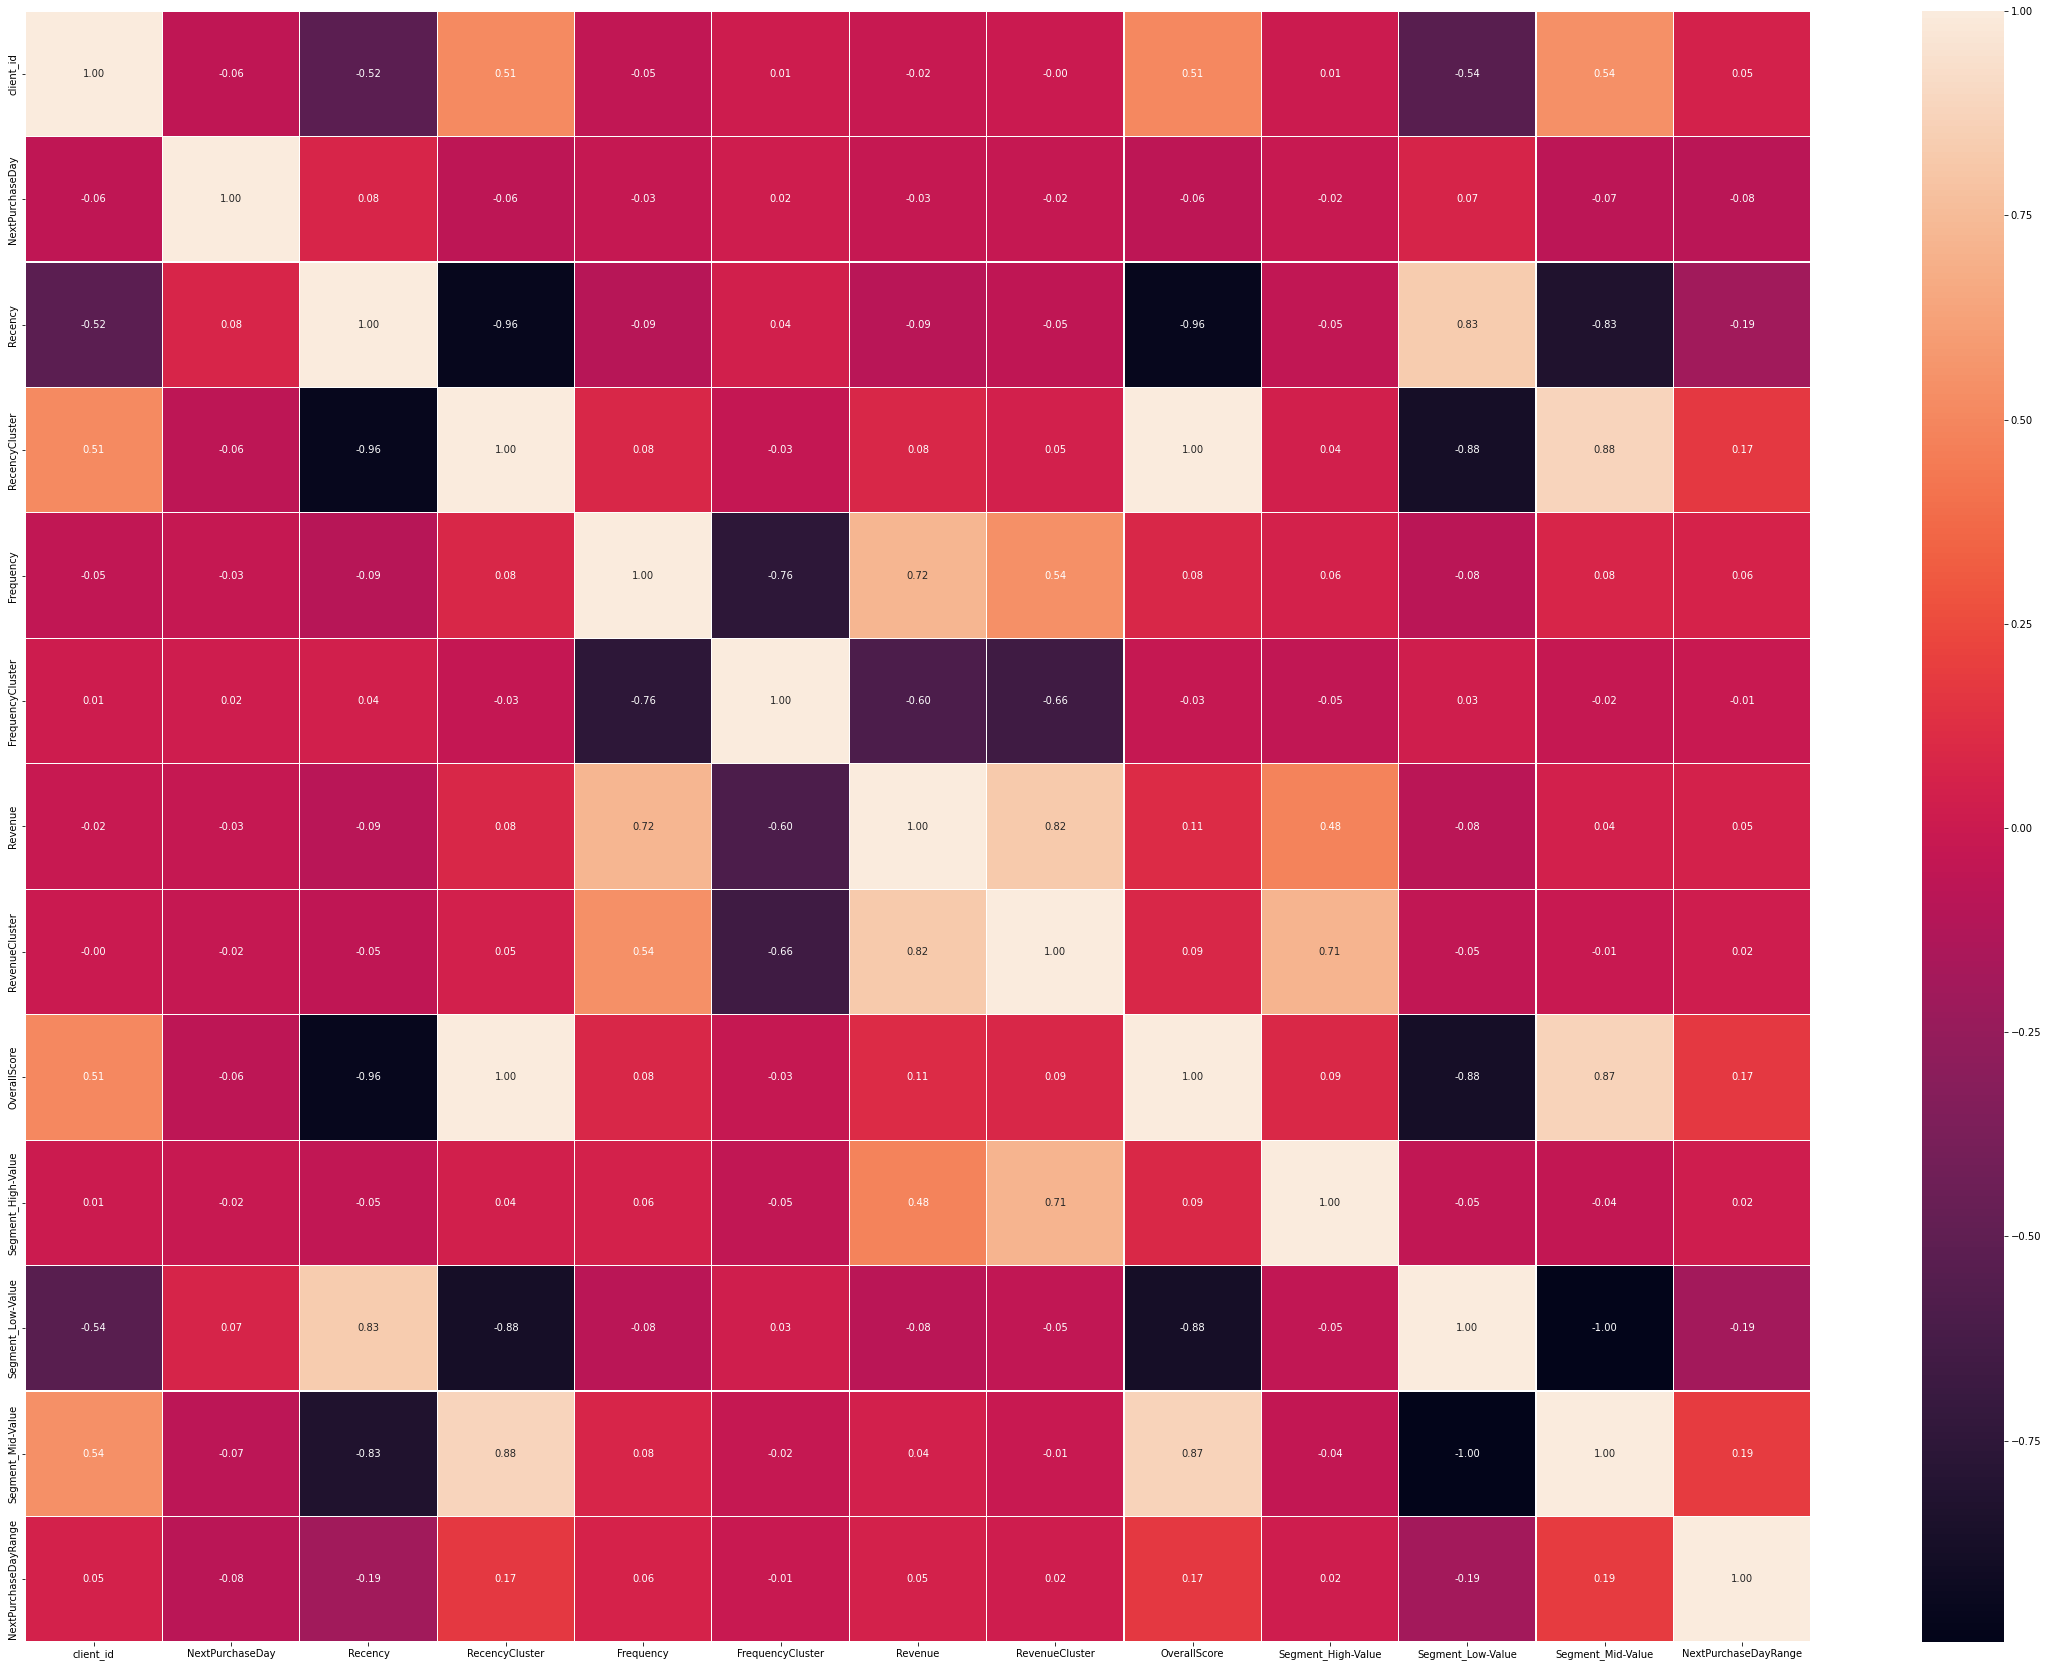

In [ ]:
plt.figure(figsize = (40, 30))
sns.heatmap(corr_matrix, annot = True, linewidths=0.2, fmt=".2f");

<a id='building-machine-learning-models'></a>
## Building Machine Learning Models

In [ ]:
ctm_class = ctm_class.drop('NextPurchaseDay', axis=1)

In [ ]:
ctm_class

,client_id,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value,NextPurchaseDayRange
0,29293,19,3,79,3,5535.00,0,6,0,0,1,3
1,29295,322,3,15,3,890.00,0,6,0,0,1,0
2,29306,368,3,29,3,1883.00,0,6,0,0,1,0
3,29311,19,3,77,3,5155.00,0,6,0,0,1,3
4,29312,32,3,157,3,10566.00,0,6,0,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
70655,349384,0,3,3226,1,261468.00,2,6,0,0,1,0
70656,444104,0,3,2182,1,226934.00,2,6,0,0,1,0
70657,118227,7,3,94,3,640311.00,3,9,1,0,0,0
70658,148152,1,3,799,2,494248.00,3,8,1,0,0,0


In [ ]:
X, y = ctm_class.drop('NextPurchaseDayRange', axis=1), ctm_class.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None, shuffle=True)

In [ ]:
#X_test

In [ ]:
# Create an array of models
models = []
models.append(("LogisticRegression", LogisticRegression()))
models.append(("GaussianNB", GaussianNB()))
models.append(("RandomForestClassifier", RandomForestClassifier()))
models.append(("SVC", SVC()))
models.append(("DecisionTreeClassifier", DecisionTreeClassifier()))
models.append(("xgb.XGBClassifier", xgb.XGBClassifier(eval_metric='mlogloss')))
models.append(("KNeighborsClassifier", KNeighborsClassifier()))

In [ ]:
# Measuring the metrics of the different models

scorer = MultiScorer({'accuracy'  : (accuracy_score , {}), 
                      'f1_score'  : (f1_score       , {'pos_label': 3, 'average':'macro'}), 
                      'recall'    : (recall_score   , {'pos_label': 3, 'average':'macro'}), 
                      'precision' : (precision_score, {'pos_label': 3, 'average':'macro'})
                     })

# A dictionary for all the distinct models and their respective metrics
model_scores_dict = {'model_name' : [], 
                     'accuracy'   : [], 
                     'f1_score'   : [], 
                     'recall'     : [], 
                     'precision'  : [],
                     'time'       : []
                    }

# For each model name and model in models
for model_name, model in models: 
    
    # Add model_name to model_scores_dict 
    model_scores_dict['model_name'].append(model_name)
    #print(model_name)
    kfold = KFold(n_splits=2, random_state=24, shuffle=True)
    start = time.time()
    _ = cross_val_score(model, X_train, y_train, cv = kfold, scoring = scorer)
    cv_result = scorer.get_results()
    
    # For each metric in cv_result.keys()
    for metric_name in cv_result.keys():
        # Get the average of cv_result[metric_name]
        average_score = np.average(cv_result[metric_name])
        # Update model_scores_dict with average_score for model_name
        model_scores_dict[metric_name].append(average_score)
        #print('%s : %f' %(metric_name, average_score))

    model_scores_dict['time'].append((time.time() - start))
    #print('time : ', time.time() - start, '\n\n')
        
model_score_df = pd.DataFrame(model_scores_dict).set_index("model_name")
model_score_df.sort_values(by=["accuracy", "f1_score", "time"], ascending=False)

,accuracy,f1_score,recall,precision,time
model_name,,,,,
LogisticRegression,0.968971,0.246060,0.250000,0.242243,5.161190
KNeighborsClassifier,0.952115,0.281971,0.304667,0.307833,3.445078
xgb.XGBClassifier,0.949574,0.285836,0.312670,0.305034,9.565518
DecisionTreeClassifier,0.945691,0.293322,0.324968,0.306871,0.177729
SVC,0.943935,0.277440,0.315915,0.295150,13.734059
RandomForestClassifier,0.935589,0.287900,0.337887,0.312786,3.720083
GaussianNB,0.920119,0.275674,0.360210,0.278237,0.146240


Let's see how we could improve the existing model `XGB` by finding suitable parameters via the process of hyperparameter tuning using `GridSearchCV`. We will check if the improved `XGB Classifier` model outperforms the `LogisticRegression` model.

In [ ]:
parameter = {
    'max_depth':range(3,10,2), 
    'min_child_weight':range(1,5,2)
    }

p_grid_search = GridSearchCV(estimator = xgb.XGBClassifier(eval_metric='mlogloss'), 
                             param_grid = parameter, 
                             scoring='accuracy', 
                             n_jobs=-1, 
                             #iid=False, 
                             cv=2
                            )

p_grid_search.fit(X_train, y_train)

GridSearchCV(cv=2, estimator=XGBClassifier(eval_metric='mlogloss'), n_jobs=-1,
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 5, 2)},
             scoring='accuracy')

In [ ]:
p_grid_search.best_params_, p_grid_search.best_score_

({'max_depth': 3, 'min_child_weight': 3}, 0.9689888196999716)

In [ ]:
import itertools    
def _plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize = 20)
    plt.xlabel('Predicted label', fontsize = 20)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.tight_layout()


In [ ]:
import pandas as pd
import numpy as np
from scipy import interp

from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df

In [ ]:
def _clf_xgboost(X, y, test_size):
    X = X.values
    clf = xgb.XGBClassifier(learning_rate = 0.05,
                                n_estimators = 100,
                                max_depth = 3,
                                min_child_weight = 1.,
                               # max_delta_step= 1,
                                gamma = 0.5,
                                reg_alpha = 0.0,
                                reg_lambda = 1.0,
                                subsample = 0.9,
                                colsample_bytree = 0.9,
                                objective = "binary:logistic",
                                nthread = 4,
                                #scale_pos_weight = (len(Y) - sum(Y)) / sum(Y),
                                base_score = np.mean(y),
                                seed = 1367,
                                random_state = 1367)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, shuffle = True, random_state = 1367, stratify = y)
    
    clf.fit(X_train, y_train, eval_metric="mlogloss", early_stopping_rounds = 50, verbose = False, eval_set=[(X_test, y_test)])
    sk_report = classification_report(digits=6, y_true=y_test, y_pred=clf.predict(X_test))
    report_with_auc = class_report(y_true=y_test,y_pred=clf.predict(X_test), y_score=clf.predict_proba(X_test))    
    
    #print('Accuracy of XGB classifier on training set: {:.2f}'
    accuracy_score_train = clf.score(X_train, y_train)
    #print('Accuracy of XGB classifier on test set: {:.2f}'
    accuracy_score_test = clf.score(X_test, y_test)
    y_pred_prob = clf.predict_proba(X_test)
    return accuracy_score_train, accuracy_score_test,X_test, y_test, sk_report,y_pred_prob, report_with_auc


In [ ]:
def _ConfidenceInterval(score, n):
    """
    confidence interval for 95% significance level
    input: score such as accuracy, auc
           the size of test set n
    """
     ## @ = 95%  Z = 1.96
     ## @ = 99%  Z = 2.57
     
    CI_range = 2.57 * np.sqrt( (score * (1 - score)) / n)
    CI_pos = score + CI_range
    CI_neg = score - CI_range
    if(CI_neg < 0):
        CI_neg = 0
        
    return CI_neg, CI_pos

In [ ]:
test_size = 0.8

accuracy_score_train, accuracy_score_test,X_test, y_test, skreport,y_pred_prob, report_auc = _clf_xgboost(X, y, test_size)
CI_neg, CI_pos = _ConfidenceInterval(accuracy_score_test, X_test.shape[0])

print(F"Accuracy for test size {test_size}  = {accuracy_score_test:.5f}")


print(F"Confidence Interval Accuracy = [{CI_neg:.3f} , {CI_pos:.3f}]")
print(skreport)
print(report_auc)



ValueError: ignored

In [ ]:
def _plot_roc_nfolds_xgboost(df_X, Y,
                                     n_folds = 10,
                                     n_estimators = 100,
                                     learning_rate = 0.05,
                                     max_depth = 7,
                                     min_child_weight = 5,
                                     gamma = 0.5,
                                     reg_alpha = 0.0,
                                     reg_lambda = 1.0,
                                     subsample = 0.9,
                                     objective = "binary:logistic",
                                     scale_pos_weight = 1.0,
                                     shuffle = True,
                                     random_state = 1367
                            ):
    """
    a function to plot k-fold cv ROC using xgboost
    input parameters:
                     df_X : features : pandas dataframe (numpy array will be built inside the function)
                     Y : targets
                     n_folds : number of cv folds (default = 10)
                     n_estimators = number of trees (default = 100)
                     learning_rate : step size of xgboost (default = 0.05)
                     max_depth : maximum tree depth for xgboost (default = 3)
                     min_child_weight : (default = 5.0)
                     gamma : (default = 0.5)
                     reg_alpha : lasso penalty (L1) (default = 0.0)
                     reg_lambda : ridge penalty (L2) (default = 1.0)
                     subsample : subsample fraction (default = 0.9)
                     objective : objective function for ML (default = "binary:logistic" for classification)
                     scale_pos_weight : (default = 1.0)
                     shuffle : shuffle flag for cv (default = True)
                     random_state : (default = 1367)
    
    """

    # Defining the data
    X = scale(df_X.values)
    y = Y
    n_samples, n_features = X.shape

    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits = n_folds , shuffle = shuffle , random_state = random_state)
    classifier = xgb.XGBClassifier(learning_rate = learning_rate,
                               n_estimators = n_estimators,
                               max_depth = max_depth,
                               min_child_weight = min_child_weight,
                               gamma = gamma,
                               reg_alpha = reg_alpha,
                               reg_lambda = reg_lambda,
                               subsample = subsample,
                               objective = objective,
                               nthread = 4,
                               scale_pos_weight = 1.,
                               base_score = np.mean(y),
                               seed = random_state,
                               random_state = random_state)
    

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    plt.figure(figsize=(18 , 13))
    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=3, alpha=0.5, 
                 label="ROC Fold %d (AUC = %0.2f)" % (i+1, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle="--", lw=3, color="k",
             label="Luck", alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color="navy",
             label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
             lw=4)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color="grey", alpha=.4,
                     label=r"$\pm$ 1 Standard Deviation")

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel("False Positive Rate" ,  fontweight = "bold" , fontsize=30)
    plt.ylabel("True Positive Rate",fontweight = "bold" , fontsize=30)
    plt.tick_params(axis="both", which="major", labelsize=20)
    plt.legend( prop={"size":20} , loc = 4)
    # plt.savefig("./roc_xgboost.pdf" ,bbox_inches="tight")
    plt.show()


In [ ]:
#_plot_roc_nfolds_xgboost(X, y)

In [ ]:
# refined_xgb_model = xgb.XGBClassifier(eval_metric='logloss', 
#                                        max_depth=list(p_grid_search.best_params_.values())[0]-1, 
#                                        min_child_weight=list(p_grid_search.best_params_.values())[-1]+4
#                                       ).fit(X_train, y_train)

# # #score_train = refined_xgb_model.score(X_train, y_train)
# # #score_test  = refined_xgb_model.score(X_test[X_train.columns], y_test)
# print('Accuracy of XGB classifier on training set: {:.2f}'.format(refined_xgb_model.score(X_train, y_train)))

# print('Accuracy of XGB classifier on test set: {:.2f}'.format(refined_xgb_model.score(X_test[X_train.columns], y_test)))


# # #CI_neg, CI_pos = _ConfidenceInterval(score_test, X_test.shape[0])
# # #print(F"Confidence Interval Accuracy = [{CI_neg:.3f} , {CI_pos:.3f}]")

As we can see, the improved `XGB classifier` model is accurate than the `LogisticRegression` model by $0.1$. 

Let us go ahead and predict with these two models.

In [ ]:
#X_test

In [ ]:
#ref_xgb_pred_y = refined_xgb_model.predict(X_test)

In [ ]:
#log_reg_pred_y = RandomForestClassifier().fit(X_train, y_train).predict(X_test)

Let compute the confusion matrices of these two models with the user-defined function `get_confusion_matrix` defined below. 

In [ ]:
# def get_confusion_matrix(y_test, y_pred):
#     """
#     Displays the confusion matrix of the input numpy arrays y_test and y_pred.
    
#     INPUT: 
#         y_test - A numpy array 
#         y_pred - A numpy array
        
#     OUTPUT:
#         NoneType
#     """
    
#     data = {'y_Actual': y_test, 'y_Predicted': y_pred}

#     df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
#     conf_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], 
#                               rownames=['Actual'], 
#                               colnames=['Predicted'])
    
#     sns.heatmap(conf_matrix, annot=True, fmt = "d", cmap="Spectral")
#     plt.show()

Let's get the confusion matrix for `y_test` and `ref_xgb_pred_y`, i.e., for the improved `XGB classifier` model and `y_test` and `log_reg_pred_y`, i.e., for the `LogisticRegression` model.

In [ ]:
#get_confusion_matrix(np.array(y_test), ref_xgb_pred_y)

In [ ]:
#get_confusion_matrix(np.array(y_test), log_reg_pred_y)

Let's check if the refined `XGB Classifier` outperforms the `LogisticRegression` for the other metrics.

In [ ]:
# # A dictionary of model names with the various metrics
# ref_xgb_log_reg_dict = {"model_name" : ["xgb.XGBClassifier", "RandomForestClassifier"], 
#                         "accuracy"   : [accuracy_score(y_test, ref_xgb_pred_y), accuracy_score(y_test, log_reg_pred_y)], 
#                         "f1_score"   : [f1_score(y_test, ref_xgb_pred_y), f1_score(y_test, log_reg_pred_y)], 
#                         "recall"     : [recall_score(y_test, ref_xgb_pred_y), recall_score(y_test, log_reg_pred_y)], 
#                         "precision"  : [precision_score(y_test, ref_xgb_pred_y), precision_score(y_test, log_reg_pred_y)]
#                        }

# # Create a dataframe with ref_xgb_log_reg_dict
# ref_xgb_log_reg_df = pd.DataFrame(ref_xgb_log_reg_dict).set_index("model_name")

# # Order the dataframe ref_xgb_log_reg_df by the metric values in increasing order
# ref_xgb_log_reg_df.sort_values(by=["accuracy", "f1_score", "recall", "precision"], ascending=False)

It is obvious from the output in the cell above that for each metric, ${\rm accuracy}$, $F_{1}-{\rm score}$, ${\rm recall}$, and ${\rm precision}$, the improved or refined `XGB classifier` model out performs the `LogisticRegression` model. Thus, we will choose the refined `XGB classifier` model over the `LogisticRegression` model. 

<a id='conclusion'></a>
## Conclusion

In summary I observed the following: 

* From the dataset, the online retail shop has 5942 customers from 41 different countries. 

* The top 3 countries are the United Kingdom, Germany and France with the United Kingdom recording the $90.85\%$ of the customers of the online retail shop. 

* The online retail shop made the highest sales in November 2010, followed by November 2011. Also, there was a rise in monthly sales after August. 

* The online retail shop got most of it revenue from customers residing in the United Kingdom followed by The Republic of Ireland, The Netherlands, Germany and France. 

* Finally, we introduced new features into our dataframe, `ctm_dt` and we builded an unsupervised machine learning model that will help us decide if customer will buy something again from the online shop in the next quarter, i.e., $90$ days from the date of his/her last purchase. Among the models that we used, we had to improve the `XGB classifier` model by the process of hyperparameter tuning to outperform the `LogisticRegression` model. 

* I also communicated the contents of this project [here](https://towardsdatascience.com/using-machine-learning-to-predict-customers-next-purchase-day-7895ad49b4db) on medium.